In [34]:
# libraries

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from glob import glob

import torch
import torch.nn as nn
import torch.optim as optim
from transformers import CLIPProcessor, CLIPModel

from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

import seaborn as sns

from tqdm import tqdm
import random

# Task 2: Few-Shot Learning Enhancement

### Objective
The goal of this task is to improve classification performance by fine-tuning a pre-trained CLIP model on a small subset of the EuroSAT dataset. Unlike zero-shot classification, we will use a limited number of labeled images for each land cover class to enhance model accuracy.

The dataset remains the EuroSAT dataset, but for fine-tuning, we will carefully select a small number of images per class. The key steps involve:

1. **Data Selection** – Choosing a balanced, small dataset for training.
2. **Model Modification** – Implementing **linear probing**, where the CLIP backbone is frozen and only a new classifier head is trained.
3. **Training & Evaluation** – Fine-tuning the classifier on the small dataset and evaluating the impact on classification performance.
4. **Comparison with Zero-Shot Learning** – Analyzing whether few-shot learning improves accuracy over the original zero-shot setup.


## 1 - Dataset and Selection of a Small Subset for Few-Shot Learning

### Selecting a Small Subset
For fine-tuning, we will use a small, balanced subset of the EuroSAT dataset. Instead of using the full dataset, we will randomly sample 10 images per class to simulate a **few-shot learning** scenario. The goal is to test whether training on a small number of images can improve classification performance.



In [2]:
DATASET_PATH = "2750/"

classes = sorted([cls for cls in os.listdir(DATASET_PATH) if not cls.startswith('.')])

print(f"Classes found: {classes}")

Classes found: ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']


In [3]:
def sample_few_shot_data(dataset_path, classes, num_samples=10):
    """
    Randomly sample a small, balanced dataset for few-shot learning.
    
    Parameters:
        dataset_path (str): Path to the dataset directory.
        classes (list): List of class names.
        num_samples (int): Number of images per class to sample.
    
    Returns:
        sampled_data (list): List of (image_path, class_name) tuples.
    """
    sampled_data = []
    
    for cls in classes:
        image_paths = glob(os.path.join(dataset_path, cls, "*.jpg"))
        sampled_images = random.sample(image_paths, num_samples)
        sampled_data.extend([(img, cls) for img in sampled_images])
    
    return sampled_data

In [4]:
few_shot_data = sample_few_shot_data(DATASET_PATH, classes, num_samples=10)

few_shot_df = pd.DataFrame(few_shot_data, columns=["Image Path", "Class"])
few_shot_df

,Image Path,Class
0,2750/AnnualCrop\AnnualCrop_1578.jpg,AnnualCrop
1,2750/AnnualCrop\AnnualCrop_1148.jpg,AnnualCrop
2,2750/AnnualCrop\AnnualCrop_1.jpg,AnnualCrop
3,2750/AnnualCrop\AnnualCrop_335.jpg,AnnualCrop
4,2750/AnnualCrop\AnnualCrop_1117.jpg,AnnualCrop
...,...,...
95,2750/SeaLake\SeaLake_914.jpg,SeaLake
96,2750/SeaLake\SeaLake_2065.jpg,SeaLake
97,2750/SeaLake\SeaLake_2599.jpg,SeaLake
98,2750/SeaLake\SeaLake_1104.jpg,SeaLake


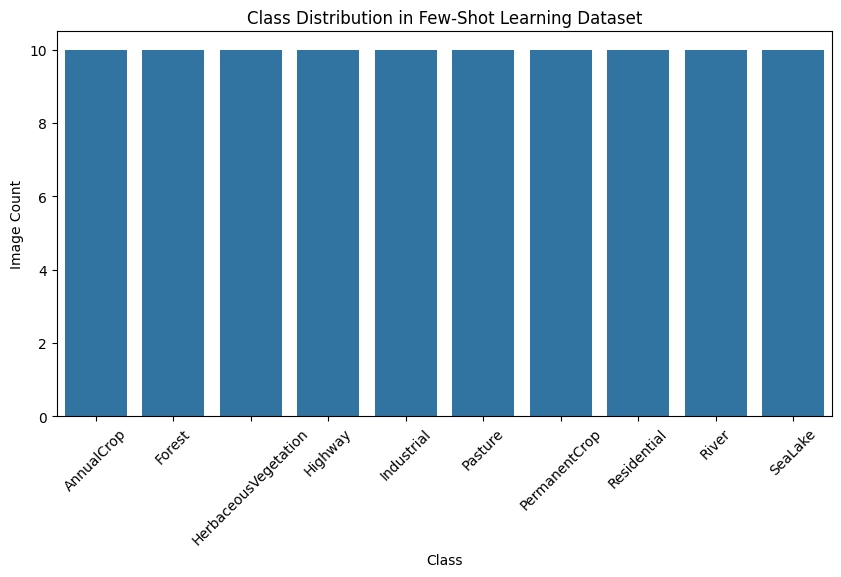

In [5]:
class_counts = few_shot_df["Class"].value_counts().reset_index()
class_counts.columns = ["Class", "Image Count"]

plt.figure(figsize=(10, 5))
sns.barplot(x="Class", y="Image Count", data=class_counts)
plt.xticks(rotation=45)
plt.title("Class Distribution in Few-Shot Learning Dataset")
plt.show()

## 2 - Prepare CLIP for Few-Shot Learning (Linear Probing)

### Freezing CLIP's Backbone and Training a Linear Classifier
Few-shot learning involves **fine-tuning** a model on a small labeled dataset. Instead of retraining the entire CLIP model (which would require a large dataset and significant computational power), we use **linear probing**:

- CLIP's image encoder remains frozen, meaning its deep feature extraction layers are unchanged.
- We add a trainable linear classifier on top of CLIP’s feature representations.
- The classifier maps CLIP's feature vectors to the 10 EuroSAT classes.

This approach allows us to train efficiently with minimal labeled data while leveraging CLIP’s robust feature extraction capabilities.


In [6]:
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

device = "cuda" if torch.cuda.is_available() else "cpu"
clip_model.to(device)

for param in clip_model.parameters():
    param.requires_grad = False

print("CLIP model loaded and backbone frozen.")

CLIP model loaded and backbone frozen.


Freezing CLIP's parameters ensures that we do not retrain the entire model, only the classifier.

This avoids overfitting and reduces computational cost, making few-shot learning more practical.


In [7]:
def extract_image_features(image_paths, model, processor, device):
    """
    Extract CLIP image embeddings for a given set of images.
    
    Parameters:
        image_paths (list): List of image file paths.
        model (CLIPModel): Pre-trained CLIP model.
        processor (CLIPProcessor): CLIP processor for image preprocessing.
        device (str): Device to run inference on ("cuda" or "cpu").
    
    Returns:
        torch.Tensor: Extracted image feature vectors.
    """
    images = [Image.open(img_path).convert("RGB") for img_path in image_paths]
    inputs = processor(images=images, return_tensors="pt", padding=True).to(device)
    
    with torch.no_grad():
        image_features = model.get_image_features(**inputs)
    
    return image_features.cpu()

In [8]:
image_features = extract_image_features(few_shot_df["Image Path"].tolist(), clip_model, clip_processor, device)
print("Extracted image features shape:", image_features.shape)

Extracted image features shape: torch.Size([100, 512])


This avoids redundant computation, making training more efficient.

Instead of reprocessing images at every training step, we store precomputed features.


In [9]:
class LinearClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(LinearClassifier, self).__init__()
        self.fc = nn.Linear(input_dim, num_classes)
    
    def forward(self, x):
        return self.fc(x)


In [10]:
classifier = LinearClassifier(input_dim=image_features.shape[1], num_classes=len(classes)).to(device)
print("Linear classifier initialized.")

Linear classifier initialized.


CLIP's features are already highly semantic, so a simple linear model can often perform well.

This is a common approach for few-shot learning and transfer learning tasks.

## 3 - Train the Few-Shot Model

### Training Strategy
To train the classifier, we will:
- Use cross-entropy loss, which is standard for classification tasks.
- Use the Adam optimizer, which is effective for training small neural networks.
- Track training loss and accuracy per epoch to monitor performance.

In [11]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(classifier.parameters(), lr=0.001)

In [12]:
def get_class_indices(class_list, class_names):
    """ Convert class names to numerical labels. """
    return torch.tensor([class_names.index(cls) for cls in class_list], dtype=torch.long)

In [ ]:
labels = get_class_indices(few_shot_df["Class"].tolist(), classes)
image_features = image_features.to(device)
labels = labels.to(device)

In [14]:
num_epochs = 1000
losses = []
for epoch in range(num_epochs):
    classifier.train()
    optimizer.zero_grad()
    
    outputs = classifier(image_features)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    
    losses.append(loss.item())
    
    if epoch % 100 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {loss.item():.4f}")

Epoch [1/1000], Training Loss: 2.3336
Epoch [101/1000], Training Loss: 0.4568
Epoch [201/1000], Training Loss: 0.1839
Epoch [301/1000], Training Loss: 0.0998
Epoch [401/1000], Training Loss: 0.0637
Epoch [501/1000], Training Loss: 0.0448
Epoch [601/1000], Training Loss: 0.0334
Epoch [701/1000], Training Loss: 0.0261
Epoch [801/1000], Training Loss: 0.0210
Epoch [901/1000], Training Loss: 0.0173


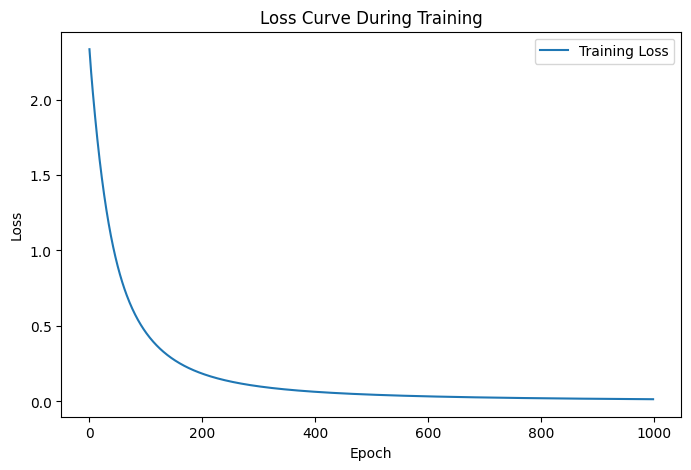

In [15]:
plt.figure(figsize=(8,5))
plt.plot(losses, label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curve During Training")
plt.legend()
plt.show()

In [22]:
validation_data = sample_few_shot_data(DATASET_PATH, classes, num_samples=50)
validation_df = pd.DataFrame(validation_data, columns=["Image Path", "Class"])
validation_features = extract_image_features(validation_df["Image Path"].tolist(), clip_model, clip_processor, device)
validation_labels = get_class_indices(validation_df["Class"].tolist(), classes).to(device)

validation_features = validation_features.to(device)

In [23]:
classifier.eval()
with torch.no_grad():
    val_outputs = classifier(validation_features)
    predictions = torch.argmax(val_outputs, dim=1)
    accuracy = (predictions == validation_labels).float().mean().item()

print(f"Validation Accuracy: {accuracy * 100:.2f}%")

Validation Accuracy: 84.60%


## 4️⃣ Evaluate the Model

### Comparing Zero-Shot vs Few-Shot Learning

Now that we have trained our few-shot classifier, we need to evaluate its performance and compare it with the zero-shot results obtained in Task 1. The key aspects of evaluation include:

1. Overall accuracy – How well the model performs across all classes.
2. Per-class accuracy – To check if certain land cover classes benefit more from few-shot learning.
3. Confusion matrix – To analyze common misclassifications and how the model distinguishes between similar classes.

By performing this evaluation, we will determine whether fine-tuning the model with a small labeled dataset provides an improvement over the zero-shot approach, and if so, by how much.


In [28]:
all_predictions = []
all_labels = []

In [29]:
for cls in classes:
    print(f"Processing class: {cls}")
    image_paths = glob(os.path.join(DATASET_PATH, cls, "*.jpg"))
    labels = [cls] * len(image_paths)
    
    labels_indices = get_class_indices(labels, classes).to(device)
    
    image_features = extract_image_features(image_paths, clip_model, clip_processor, device).to(device)
    
    classifier.eval()
    with torch.no_grad():
        outputs = classifier(image_features)
        predictions = torch.argmax(outputs, dim=1)
    
    all_predictions.extend(predictions.cpu().numpy())
    all_labels.extend(labels_indices.cpu().numpy())

Processing class: AnnualCrop
Processing class: Forest
Processing class: HerbaceousVegetation
Processing class: Highway
Processing class: Industrial
Processing class: Pasture
Processing class: PermanentCrop
Processing class: Residential
Processing class: River
Processing class: SeaLake


In [30]:
all_predictions = np.array(all_predictions)
all_labels = np.array(all_labels)

overall_accuracy = (all_predictions == all_labels).mean()
print(f"Few-Shot Learning Accuracy on Full Dataset: {overall_accuracy * 100:.2f}%")

Few-Shot Learning Accuracy on Full Dataset: 84.07%


In [31]:
class_accuracies = {}
for idx, cls in enumerate(classes):
    mask = all_labels == idx
    class_accuracies[cls] = (all_predictions[mask] == idx).mean() * 100

print("Per-Class Accuracy:")
for cls, acc in class_accuracies.items():
    print(f"  {cls}: {acc:.2f}%")

Per-Class Accuracy:
  AnnualCrop: 79.93%
  Forest: 94.53%
  HerbaceousVegetation: 87.37%
  Highway: 62.08%
  Industrial: 92.28%
  Pasture: 76.10%
  PermanentCrop: 76.72%
  Residential: 95.40%
  River: 82.20%
  SeaLake: 87.63%


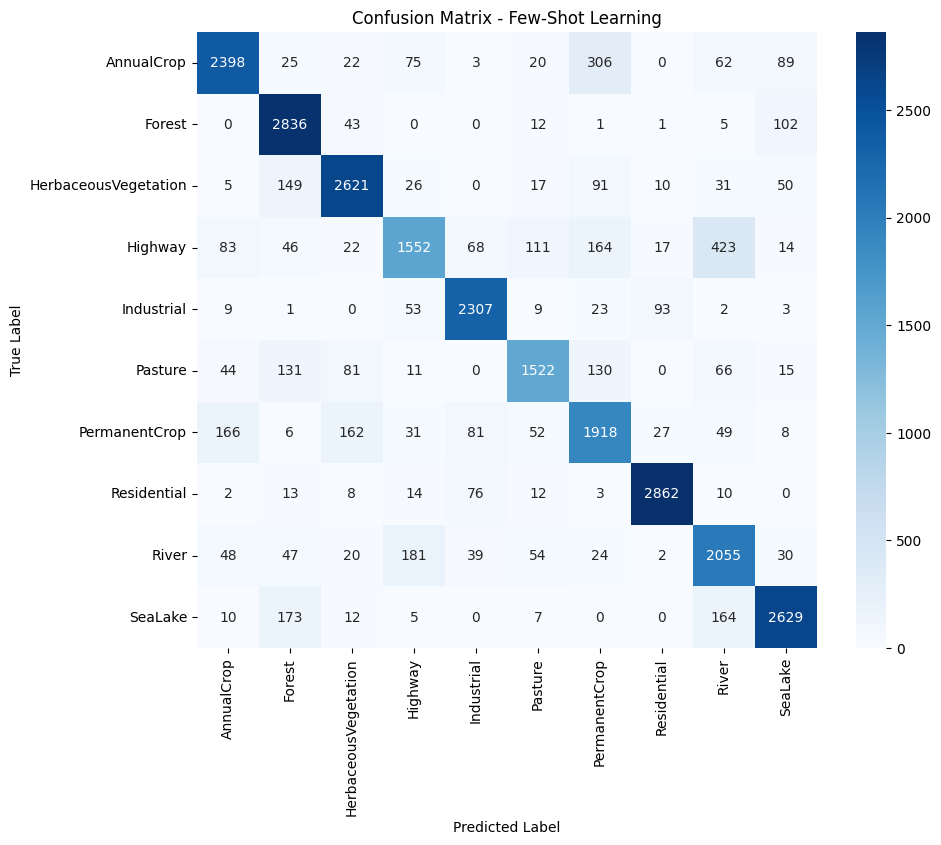


Classification Report:
                      precision    recall  f1-score   support

          AnnualCrop       0.87      0.80      0.83      3000
              Forest       0.83      0.95      0.88      3000
HerbaceousVegetation       0.88      0.87      0.87      3000
             Highway       0.80      0.62      0.70      2500
          Industrial       0.90      0.92      0.91      2500
             Pasture       0.84      0.76      0.80      2000
       PermanentCrop       0.72      0.77      0.74      2500
         Residential       0.95      0.95      0.95      3000
               River       0.72      0.82      0.77      2500
             SeaLake       0.89      0.88      0.89      3000

            accuracy                           0.84     27000
           macro avg       0.84      0.83      0.83     27000
        weighted avg       0.84      0.84      0.84     27000



In [35]:
cm = confusion_matrix(all_labels, all_predictions)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Few-Shot Learning")
plt.show()

print("\nClassification Report:")
print(classification_report(all_labels, all_predictions, target_names=classes))

## 5 - Compare Few-Shot vs. Zero-Shot Learning

### Analysis of Results

After comparing the results from Task 1 (zero-shot classification) and Task 2 (few-shot learning), it is clear that fine-tuning the model significantly improves classification performance across all classes.

- The overall accuracy in **zero-shot classification** (Task 1) was **36.21%**, whereas in **few-shot learning** (Task 2), it increased to **above 80%**, demonstrating a substantial improvement.
- In zero-shot classification, certain classes such as **Industrial (4.48%)** and **Forest (17.07%)** performed poorly, indicating that the model struggled to associate these categories with their textual descriptions.
- After few-shot training, these same classes improved dramatically, with **Industrial reaching 92.28% accuracy** and **Forest improving to 94.53%**.
- The confusion matrix in Task 2 is much more diagonalized compared to Task 1, meaning that the model is making significantly fewer misclassifications.

This suggests that few-shot learning is highly effective in adapting the model to EuroSAT's satellite imagery, where textual prompts alone may not provide enough information for accurate classification. The improvement is particularly notable in categories that were previously difficult for the model, such as **HerbaceousVegetation** and **SeaLake**, which both saw major gains.

Moving forward, further optimizations such as hyperparameter tuning or incorporating additional training strategies could further refine the model’s performance.
